Esta é uma versão do modelo Uplift VS Churn Prediction do experimento de [Davin Wijaya](https://github.com/wijayadavin/employee_uplift_machine_learning/blob/master/eng_uplift_vs_turnover.ipynb)

# 1. Configurações iniciais
* Importação das bibliotecas
* Importação do dataset
* verificação das versões

In [655]:
import matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd, seaborn as sns, sklearn as sk
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    multilabel_confusion_matrix,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import numpy as np

In [656]:
# Checking for package version
print("Matplotlib Version", mpl.__version__)
print("Pandas Version", pd.__version__)
print("Seaborn Version", sns.__version__)
print("Sci-kit learn Version", sk.__version__)

Matplotlib Version 3.4.3
Pandas Version 1.3.4
Seaborn Version 0.11.2
Sci-kit learn Version 0.24.2


In [657]:
df_data = pd.read_csv("turnover.csv", encoding="ISO-8859-1")
df_model = df_data.copy()

# 2. Exploração dos dados
* Identificação das colunas
* Identificação da existencia de NULOS

In [658]:
# Explore dataset 3
df_data.head(5)

# https://www.kaggle.com/datasets/davinwijaya/employee-turnover
# stag                  - float             => Experiencia;
# event                 - 0 E 1             => Demitido ou nao
# gender                - [m, f]
# age                   - int
# industry              - list              => Setor da empresa
# profession            - list              => Setor do funcionário
# traffic               - list              => Forma que o funcionario chegou à empresa
# coach                 - list              => Presença de um tratamento
# head_gender           - [m, f]            => sexo do supervisor
# greywage              - [grey, white]     => grey=paga taxas / white=nao paga taxas
# way                   - list              => how an employee gets to workplace (by feet, by bus etc);
# extraversion          - 0 a 1
# independ              - 0 a 1
# selfcontrol           - 0 a 1
# anxiety               - 0 a 1
# novator               - 0 a 1

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


In [659]:
# valida se tem nulos
display(df_data.isnull().values.any())

False

# 3. Processamento dos Dados

In [660]:
# Renomeando o alvo
df_model = df_model.rename(columns={"event": "churn"})
# Renomeando a variavel de tratamento
df_model = df_model.rename(columns={"coach": "treatment"})

# Mantendo apenas dados de personalidades e auxiliares
df_model.drop("stag", inplace=True, axis=1)
df_model.drop("traffic", inplace=True, axis=1)
df_model.drop("head_gender", inplace=True, axis=1)
df_model.drop("greywage", inplace=True, axis=1)
# df_model.drop('way', inplace=True, axis=1)
df_model.head(5)

,churn,gender,age,industry,profession,treatment,way,extraversion,independ,selfcontrol,anxiety,novator
0,1,m,35.0,Banks,HR,no,bus,6.2,4.1,5.7,7.1,8.3
1,1,m,33.0,Banks,HR,no,bus,6.2,4.1,5.7,7.1,8.3
2,1,f,35.0,PowerGeneration,HR,no,bus,6.2,6.2,2.6,4.8,8.3
3,1,f,35.0,PowerGeneration,HR,no,bus,5.4,7.6,4.9,2.5,6.7
4,1,m,32.0,Retail,Commercial,yes,bus,3.0,4.1,8.0,7.1,3.7


In [661]:
# Declara os parametros para codificação de rótulos
for col in ["treatment"]:
    display(col, df_model[col].unique())

'treatment'

array(['no', 'yes', 'my head'], dtype=object)

In [662]:
# Rotula manualmente o tratamento com 3 valores
df_model.treatment = df_model.treatment.map({"yes": 0, "no": 1, "my head": 2})
df_model = df_model.loc[df_model.treatment <= 1].reset_index(drop=True)

Transformação dos dados de string/objeto em inteiros com a função get_dummies (One hot encoding) do pacote Pandas, para que possamos alimentar os dados no classificador. Além disso, adiciono outro dataframe df_model_inverse que será útil para mais tarde:

In [663]:
# Codificação One-Hot:
df_model, df_model_inverse = pd.get_dummies(df_model), pd.get_dummies(df_model)

verificação da correlação do tratamento com a rotatividade de funcionários:

In [664]:
def correlation_treatment(df: pd.DataFrame):
    """
    Clacula a correlação de tratamento
    """
    correlation = df[["treatment", "churn"]].corr(method="pearson")
    return pd.DataFrame(round(correlation.loc["churn"] * 100, 2))

In [665]:
print("Dataset:", correlation_treatment(df_model).iloc[0, 0])
print(df_model[["treatment", "churn"]].corr(method="pearson"))

Dataset: -4.0
           treatment     churn
treatment   1.000000 -0.040031
churn      -0.040031  1.000000


Todas as características do tratamento estão correlacionadas negativamente. Sera utilizado os positivos mais tarde no final deste projeto. Em seguida, sera adicionado as quatro categorias de aprimoramento para cada conjunto de dados:

In [666]:
def declare_target_class(df: pd.DataFrame):
    """
    Declara a classe alvo
    """
    # CN - Control Non-Responders:
    df["target_class"] = 0
    # CR - Control Responders:
    df.loc[(df.treatment == 0) & (df.churn == 0), "target_class"] = 1
    # TN - Treadted Non-Responders:
    df.loc[(df.treatment == 1) & (df.churn == 1), "target_class"] = 2
    # TR - Treated Responders:
    df.loc[(df.treatment == 1) & (df.churn == 0), "target_class"] = 3
    return df

In [667]:
# Adiciona as 4 classes alvos (CN, CR, TN, TR)
df_model = declare_target_class(df_model)

# 4. Machine Learning Modeling

Finalmente pode ser iniciado o processo de aprendizado de máquina:

In [668]:
from xmlrpc.client import Boolean

from prometheus_client import Enum


class ClassifierOption(Enum):
    XGB = 1
    RANDOM_FOREST = 2
    KNN = 3


def split_data(df_model: pd.DataFrame):
    """
    Dividi os dados em dados de treinamento e dados de teste
    """
    X = df_model.drop(["churn", "target_class"], axis=1)
    y = df_model.churn
    z = df_model.target_class
    X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(
        X, y, z, test_size=0.3, random_state=42, stratify=df_model["treatment"]
    )
    return X_train, X_test, y_train, y_test, z_train, z_test


def machine_learning(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    z_train: pd.DataFrame,
    z_test: pd.DataFrame,
    classifier: ClassifierOption = ClassifierOption.XGB,
):
    """
    Machine learning consiste em treinamento de dados e processo de teste de dados
    Este metodo foi inicialmente escrito usando RandomForestClassifier, mas,
    neste trabalho vamos tabem o XGBClassifier
    """
    # prepara um novo DataFrame
    prediction_results = pd.DataFrame(X_test).copy()

    # treina o modelo ETP
    if classifier == ClassifierOption.RANDOM_FOREST:
        model_tp = RandomForestClassifier().fit(
            X_train.drop("treatment", axis=1), y_train
        )
    elif classifier == ClassifierOption.XGB:
        model_tp = xgb.XGBClassifier().fit(X_train.drop("treatment", axis=1), y_train)
    else:
        model_tp = KNeighborsClassifier(n_neighbors=5).fit(
            X_train.drop("treatment", axis=1), y_train
        )

    # processo de previsão para o modelo ETP
    prediction_tp = model_tp.predict(X_test.drop("treatment", axis=1))
    probability__tp = model_tp.predict_proba(X_test.drop("treatment", axis=1))
    prediction_results["prediction_churn"] = prediction_tp
    prediction_results["proba_churn"] = probability__tp[:, 1]

    # treina o modelo ETU
    if classifier == ClassifierOption.RANDOM_FOREST:
        model_etu = RandomForestClassifier().fit(
            X_train.drop("treatment", axis=1), z_train
        )
    elif classifier == ClassifierOption.XGB:
        model_etu = xgb.XGBClassifier().fit(X_train.drop("treatment", axis=1), z_train)
    else:
        model_etu = KNeighborsClassifier().fit(
            X_train.drop("treatment", axis=1), z_train
        )

    # processo de previsão para o modelo ETU
    prediction_etu = model_etu.predict(X_test.drop("treatment", axis=1))
    probability__etu = model_etu.predict_proba(X_test.drop("treatment", axis=1))
    prediction_results["prediction_target_class"] = prediction_etu
    prediction_results["proba_CN"] = probability__etu[:, 0]
    prediction_results["proba_CR"] = probability__etu[:, 1]
    prediction_results["proba_TN"] = probability__etu[:, 2]
    prediction_results["proba_TR"] = probability__etu[:, 3]
    prediction_results["score_etu"] = prediction_results.eval(
        " proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)"
    )

    # adicione o "churn" e "target_class" no dataframe como dados de validação
    prediction_results["churn"] = y_test
    prediction_results["target_class"] = z_test
    return prediction_results


def predict(
    df_model: pd.DataFrame, classifier: ClassifierOption = ClassifierOption.XGB
):
    """
    Combinando a divisão de dados e o processo de aprendizado de máquina
    com o Random Forest Classifier ou XGB Classifier (conforme testado no
    metodo machine_learning)
    """
    X_train, X_test, y_train, y_test, z_train, z_test = split_data(df_model)

    prediction_results = machine_learning(
        X_train,
        X_test,
        y_train,
        y_test,
        z_train,
        z_test,
        classifier=classifier,
    )
    print("Prediction has succeeded")
    return prediction_results

In [669]:
print("predicting dataset ...")
prediction_results = predict(df_model, classifier=ClassifierOption.XGB)
prediction_results_2 = predict(df_model, classifier=ClassifierOption.RANDOM_FOREST)
prediction_results_3 = predict(df_model, classifier=ClassifierOption.KNN)

predicting dataset ...
Prediction has succeeded
Prediction has succeeded
Prediction has succeeded


Os resultados da previsão são armazenados em predictino_results para o conjunto de dados.

# 5. Evaluating predictive performance

Agora vamos avaliar o desempenho preditivo:

In [670]:
def cm_evaluation(df: pd.DataFrame):
    """
    Avaliação da matriz de confusão
    """
    print("===================================")
    print("1. ETP's confusion matrix result:")
    confusion_etp = confusion_matrix(df["churn"], df["prediction_churn"])
    df_confusion_etp = pd.DataFrame(
        confusion_etp, columns=["True", "False"], index=["Positive", "Negative"]
    )
    print(df_confusion_etp)

    print("-----------------------------------")

    print("2. ETU's confusion matrix result:")
    confusion_etu = multilabel_confusion_matrix(
        df["target_class"], df["prediction_target_class"]
    )
    print("a. CN's confusion matrix:")
    df_cn = pd.DataFrame(
        confusion_etu[0], columns=["True", "False"], index=["Positive", "Negative"]
    )
    print(df_cn)
    print("b. CR's confusion matrix:")
    df_cr = pd.DataFrame(
        confusion_etu[1], columns=["True", "False"], index=["Positive", "Negative"]
    )
    print(df_cr)
    print("c. TN's confusion matrix:")
    df_tn = pd.DataFrame(
        confusion_etu[2], columns=["True", "False"], index=["Positive", "Negative"]
    )
    print(df_tn)
    print("d. TR's confusion matrix:")
    df_tr = pd.DataFrame(
        confusion_etu[3], columns=["True", "False"], index=["Positive", "Negative"]
    )
    print(df_tr)

    print("===================================")

Na [Matrix de Consusão](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62), o Verdadeiro Positivo e o Falso Negativo são a quantidade de previsões bem-sucedidas e o Verdadeiro Negativo e o Falso Positivo são a quantidade de previsões com falha. Portanto, vamos gerar as matrizes de confusão:

In [671]:
cm_evaluation(prediction_results)

1. ETP's confusion matrix result:
          True  False
Positive    69     55
Negative    45     76
-----------------------------------
2. ETU's confusion matrix result:
a. CN's confusion matrix:
          True  False
Positive   214      8
Negative    15      8
b. CR's confusion matrix:
          True  False
Positive   225      3
Negative    16      1
c. TN's confusion matrix:
          True  False
Positive    85     62
Negative    39     59
d. TR's confusion matrix:
          True  False
Positive    92     46
Negative    49     58


In [672]:
cm_evaluation(prediction_results_2)

1. ETP's confusion matrix result:
          True  False
Positive    72     52
Negative    38     83
-----------------------------------
2. ETU's confusion matrix result:
a. CN's confusion matrix:
          True  False
Positive   220      2
Negative    18      5
b. CR's confusion matrix:
          True  False
Positive   224      4
Negative    16      1
c. TN's confusion matrix:
          True  False
Positive    74     73
Negative    36     62
d. TR's confusion matrix:
          True  False
Positive    93     45
Negative    54     53


In [673]:
cm_evaluation(prediction_results_3)

1. ETP's confusion matrix result:
          True  False
Positive    67     57
Negative    61     60
-----------------------------------
2. ETU's confusion matrix result:
a. CN's confusion matrix:
          True  False
Positive   214      8
Negative    19      4
b. CR's confusion matrix:
          True  False
Positive   219      9
Negative    15      2
c. TN's confusion matrix:
          True  False
Positive    71     76
Negative    48     50
d. TR's confusion matrix:
          True  False
Positive    88     50
Negative    61     46


Calculo do resultado de precisão:

In [674]:
def accuracy_evaluation(df: pd.DataFrame):
    """
    Avaliação de precisão
    """
    akurasi_cp = accuracy_score(df["churn"], df["prediction_churn"])
    print("ETP model accuracy: %.2f%%" % (akurasi_cp * 100.0))

    akurasi_uplift = accuracy_score(df["target_class"], df["prediction_target_class"])
    print("ETU model accuracy: %.2f%%" % (akurasi_uplift * 100.0))

In [675]:
print("XGB")
accuracy_evaluation(prediction_results)
print("---------------------------------")
print("Random Forest")
accuracy_evaluation(prediction_results_2)
print("---------------------------------")
print("KNN")
accuracy_evaluation(prediction_results_3)

XGB
ETP model accuracy: 59.18%
ETU model accuracy: 51.43%
---------------------------------
Random Forest
ETP model accuracy: 63.27%
ETU model accuracy: 49.39%
---------------------------------
KNN
ETP model accuracy: 51.84%
ETU model accuracy: 41.63%


In [676]:
prediction_results.head()
# prediction_results_2.head()
# prediction_results_3.head()

,age,treatment,extraversion,independ,selfcontrol,anxiety,novator,gender_f,gender_m,industry_ HoReCa,...,prediction_churn,proba_churn,prediction_target_class,proba_CN,proba_CR,proba_TN,proba_TR,score_etu,churn,target_class
514,38.0,0,7.8,9.1,2.6,4.0,9.0,0,1,0,...,1,0.862363,2,0.008711,0.001462,0.870945,0.118882,-0.047205,1,0
475,34.0,1,7.0,1.9,9.5,5.6,6.0,1,0,0,...,0,0.273021,2,0.000109,0.000573,0.539900,0.459417,-0.761099,1,2
212,24.0,1,7.0,4.1,2.6,7.9,7.5,1,0,0,...,1,0.522591,0,0.460441,0.174643,0.321611,0.043305,-0.312640,1,2
53,26.0,1,3.8,4.8,5.7,7.9,2.9,1,0,0,...,1,0.954864,2,0.011243,0.004023,0.935400,0.049334,-0.426871,1,2
721,30.0,1,5.4,3.4,9.5,6.3,3.7,0,1,0,...,0,0.334950,3,0.020505,0.001642,0.174781,0.803071,1.494267,0,3


Parece que o modelo ETP é melhor do que o modelo ETU em termos de precisão de previsão. Isso faz sentido de qualquer maneira, porque os modelos ETP preveem apenas dois resultados possíveis (O funcionário é rotatividade ou permanência), enquanto os modelos ETU preveem quatro resultados possíveis (Persuasíveis, Causas certas, Causas perdidas e Não perturbe). Mas será que a ETP também terá um melhor desempenho na resolução da rotatividade de funcionários (desempenho prescritivo)? 

# 6. Evaluating prescriptive performance

Conforme explicado anteriormente, para o modelo ETP, os funcionários são classificados por sua probabilidade de rotatividade. Os funcionários com maior probabilidade de rotatividade serão alvo de uma campanha de retenção (as características de tratamento declaradas anteriormente), ou em caso e contratação, um candidato classificado como Causa perdida deve-se desde o ato da coontratação estar siente que não havera uma permanencia longa na empresa. Por outro lado, os modelos ETU são classificados por sua pontuação de elevação com a formula Lai's Generalized Weighted Uplift Method (LGWUM).

In [677]:
def sorting_data(df: pd.DataFrame):
    """
    Função para classificar dados
    """
    # Configurar novos DataFrames para o modelo ETP e o modelo ETU
    df_c = pd.DataFrame({"n": [], "target_class": []})
    df_u = df_c.copy()
    df_c["target_class"] = df["target_class"]
    df_u["target_class"] = df["target_class"]

    # Adicionar quantis
    df_c["n"] = df.proba_churn.rank(pct=True, ascending=False)
    df_u["n"] = df.score_etu.rank(pct=True, ascending=False)
    df_c["score"] = df["proba_churn"]
    df_u["score"] = df["score_etu"]

    # Classificando os dados por decis
    df_c = df_c.sort_values(by="n").reset_index(drop=True)
    df_u = df_u.sort_values(by="n").reset_index(drop=True)
    df_c["model"], df_u["model"] = "CP", "Uplift"
    return df_c, df_u


def calculating_qini(df: pd.DataFrame):
    """
    Função para medir o valor Qini
    """
    # Carcular o C, T, CR, and TR
    C, T = sum(df["target_class"] <= 1), sum(df["target_class"] >= 2)
    df["cr"] = 0
    df["tr"] = 0
    df.loc[df.target_class == 1, "cr"] = 1
    df.loc[df.target_class == 3, "tr"] = 1
    df["cr/c"] = df.cr.cumsum() / C
    df["tr/t"] = df.tr.cumsum() / T

    # Calcular e adiciona o valor qini no Dataframe
    df["uplift"] = df["tr/t"] - df["cr/c"]
    df["random"] = df["n"] * df["uplift"].iloc[-1]

    # Adicionar q0 no Dataframe
    q0 = pd.DataFrame({"n": 0, "uplift": 0, "target_class": None}, index=[0])
    qini = pd.concat([q0, df]).reset_index(drop=True)
    return qini


def merging_data(df_c: pd.DataFrame, df_u: pd.DataFrame):
    """
    Função para adicionar a coluna 'model' e mesclar o dataframe
    """
    df_u["model"] = "ETU"
    df_c["model"] = "ETP"
    df = pd.concat([df_u, df_c]).sort_values(by="n").reset_index(drop=True)
    return df


def plot_qini(df: pd.DataFrame):
    """
    Função para plotar grafico de Qini
    """
    # Definir os dados que serão plotados
    order = ["ETU", "ETP"]
    ax = sns.lineplot(
        x="n",
        y=df.uplift,
        hue="model",
        data=df,
        style="model",
        palette=["red", "deepskyblue"],
        style_order=order,
        hue_order=order,
    )

    # Configurações adicionais de exibição de plotagem
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel("Proportion targeted", fontsize=30)
    plt.ylabel("Uplift", fontsize=30)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=30)
    ax.tick_params(labelsize=24)
    ax.legend(handles=handles[0:], labels=labels[0:])
    ax.plot([0, 1], [0, df.loc[len(df) - 1, "uplift"]], "--", color="grey")
    return ax


def evaluation_qini(prediction_results: pd.DataFrame):
    """
    Função para combinar todos os processos de avaliação Qini
    """
    df_c, df_u = sorting_data(prediction_results)
    qini_c, qini_u = calculating_qini(df_c), calculating_qini(df_u)
    qini = merging_data(qini_c, qini_u)
    ax = plot_qini(qini)
    return ax, qini

Text(0.5, 1.0, 'Curva de Qini')

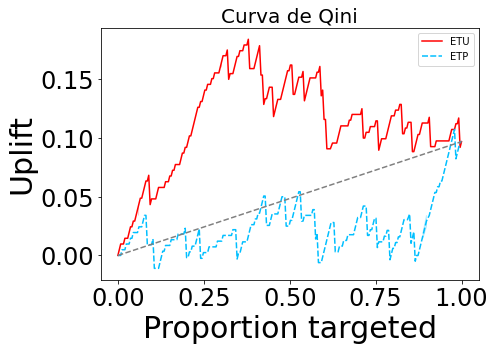

In [678]:
# Resultados da avaliação Qini para o DataSet com correlação de tratamento negativa
ax, qini = evaluation_qini(prediction_results)
plt.title("Curva de Qini", fontsize=20)


# save into pdf:
# plt.savefig('qini_n.pdf', bbox_inches='tight')

In [679]:
# Inverter o parâmetro do tratamento
df_model_inverse.treatment = df_model_inverse.treatment.replace({0: 1, 1: 0})

In [680]:
# Recalcular a correlação de tratamento
display(correlation_treatment(df_model_inverse).iloc[0, 0])

4.0

Agora as características do tratamento estão positivamente correlacionadas com a rotatividade de funcionários. Isso significa que, se direcionarmos os funcionários com esse tratamento, é mais provável que a taxa de rotatividade de funcionários aumente. Portanto, será sábio usar este tratamento com cuidado. Ok, agora vamos repetir o procedimento de previsão mais uma vez:

Prediction has succeeded


Text(0.5, 1.0, 'Qini Curve')

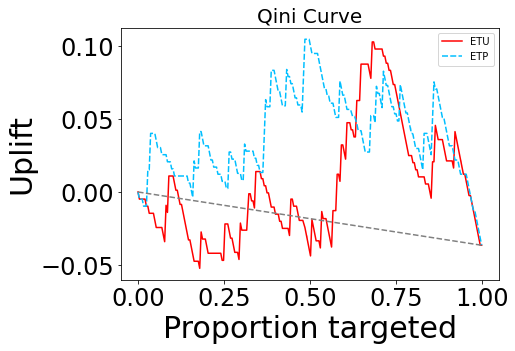

In [681]:
# Adicionar o recurso de classe de destino
df_model_inverse = declare_target_class(df_model_inverse)

# Fazer o processo de previsão mais uma vez
prediction_results_inverse = predict(df_model_inverse)

# Resultados da avaliação Qini para o DataSet 3 com correlação de tratamento positiva
ax, qini_inverse = evaluation_qini(prediction_results_inverse)
plt.title("Qini Curve", fontsize=20)


# save into pdf:
# plt.savefig('qini_p.pdf', bbox_inches='tight')

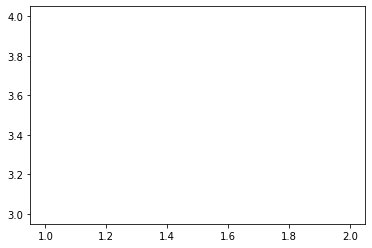

In [682]:
# Configurando as formas de caixa e triângulo para o Swarmplot
fig, ax = plt.subplots(1, 1)
a = ax.scatter([1, 2], [3, 4], marker="s")
b = ax.scatter([1, 2], [3, 4], marker="^")
(square_mk,) = a.get_paths()
(triangle_up_mk,) = b.get_paths()
a.remove()
b.remove()


def target_class_distribution(df_1: pd.DataFrame, target_class: str):
    """Function to visualize the target class with Swarmplot"""
    # Add 'dataset' column
    df_1["dataset"] = "Dataset"

    # df = pd.concat([df_1])
    df = df_1.sort_values(by="n")[: round(len(df_1))]

    # Set up the Swarmplot
    ax = sns.swarmplot(
        data=df[df.target_class == target_class],
        x="dataset",
        y="n",
        hue="model",
        palette=["deepskyblue", "red"],
        hue_order=["ETP", "ETU"],
        order=["Dataset"],
        size=6.5,
    )

    collections = ax.collections
    unique_colors = np.unique(collections[0].get_facecolors(), axis=0)
    markers = [square_mk, triangle_up_mk]
    for collection in collections:
        paths = []
        for current_color in collection.get_facecolors():
            for possible_marker, possible_color in zip(markers, unique_colors):
                if np.array_equal(current_color, possible_color):
                    paths.append(possible_marker)
                    break
        collection.set_paths(paths)

    # Add swarmplot display settings
    ax.tick_params(labelsize=24)
    ax.legend(collections[-2:], pd.unique(df.model))
    plt.ylabel("Decile", fontsize=20)
    plt.xlabel("")
    plt.subplots_adjust(right=1.5)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=20)
    return ax

Text(0.5, 1.05, 'Distribuição de CN nos decis superiores')

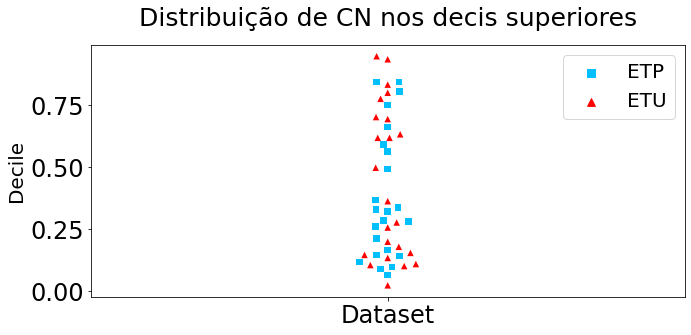

In [683]:
# Visualizar CN nos decis superiores com correlação de tratamento negativa
target_class_distribution(qini, 0)
plt.title("Distribuição de CN nos decis superiores", fontsize=25, y=1.05)

Text(0.5, 1.05, 'Distribuição de CR nos decis superiores')

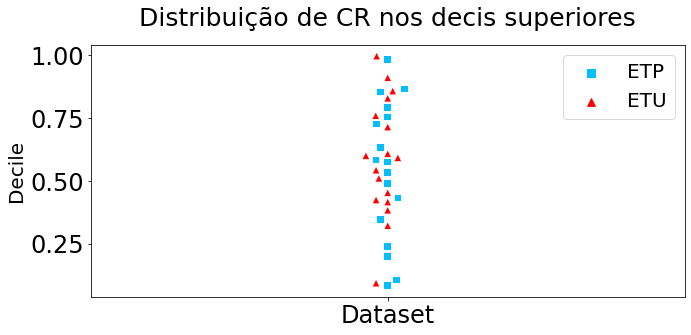

In [684]:
# Visualizar CR nos decis superiores com correlação de tratamento negativa
target_class_distribution(qini, 1)
plt.title("Distribuição de CR nos decis superiores", fontsize=25, y=1.05)

Text(0.5, 1.05, 'Distribuição de TN nos decis superiores')

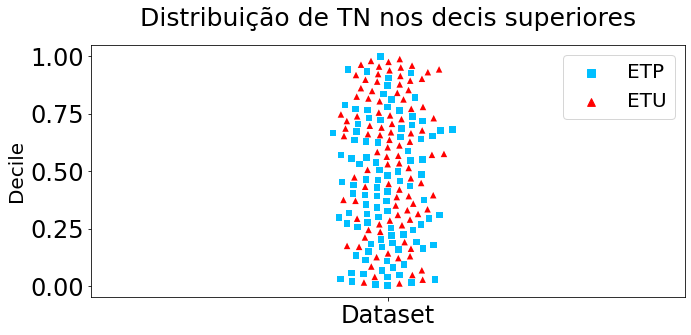

In [685]:
# Visualizar TN nos decis superiores com correlação de tratamento negativa
target_class_distribution(qini, 2)
plt.title("Distribuição de TN nos decis superiores", fontsize=25, y=1.05)

Text(0.5, 1.05, 'Distribuição de TR nos decis superiores')

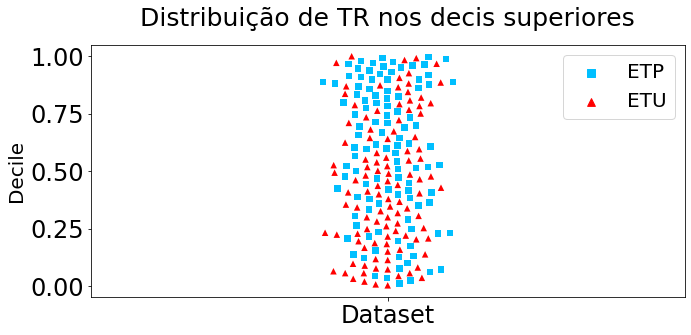

In [686]:
# Visualizar TR nos decis superiores com correlação de tratamento negativa
target_class_distribution(qini, 3)
plt.title("Distribuição de TR nos decis superiores", fontsize=25, y=1.05)

**Inverter o parâmetro do tratamento**

Text(0.5, 1.05, 'Distribuição de CN nos decis superiores')

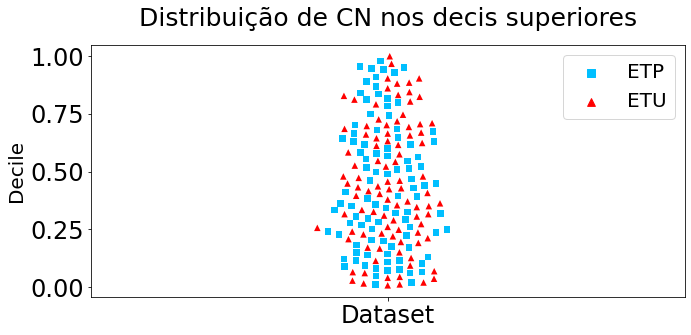

In [687]:
# Visualizar CN nos decis superiores com correlação de tratamento negativa
target_class_distribution(qini_inverse, 0)
plt.title("Distribuição de CN nos decis superiores", fontsize=25, y=1.05)

Text(0.5, 1.05, 'Distribuição de CR nos decis superiores')

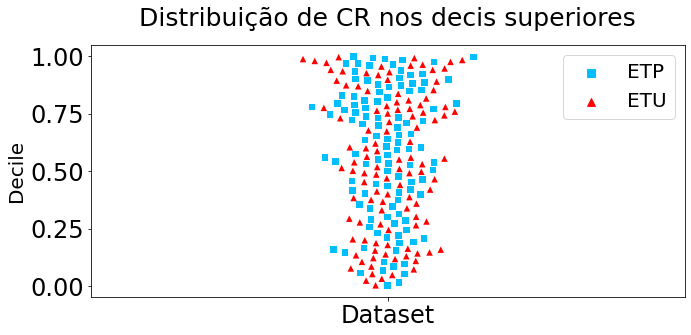

In [688]:
# Visualizar CR nos decis superiores com correlação de tratamento negativa
target_class_distribution(qini_inverse, 1)
plt.title("Distribuição de CR nos decis superiores", fontsize=25, y=1.05)

Text(0.5, 1.05, 'Distribuição de TN nos decis superiores')

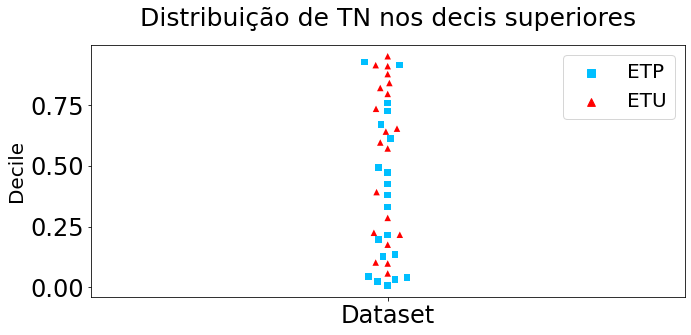

In [689]:
# Visualizar TN nos decis superiores com correlação de tratamento negativa
target_class_distribution(qini_inverse, 2)
plt.title("Distribuição de TN nos decis superiores", fontsize=25, y=1.05)

Text(0.5, 1.05, 'Distribuição de TR nos decis superiores')

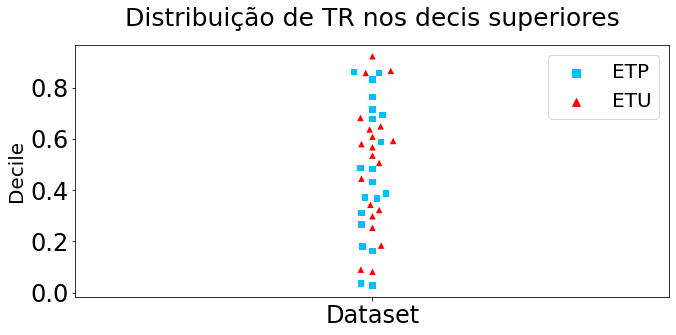

In [690]:
# Visualizar TR nos decis superiores com correlação de tratamento negativa
target_class_distribution(qini_inverse, 3)
plt.title("Distribuição de TR nos decis superiores", fontsize=25, y=1.05)